In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import utils
import network
import os
from PIL import Image
import cv2
from tqdm.notebook import tqdm, trange
plt.style.use('seaborn-v0_8-whitegrid')

### 2.1, 2.2, 2.3, 2.4
- ```Note that the required functions are defined in the "utils.py" file.```

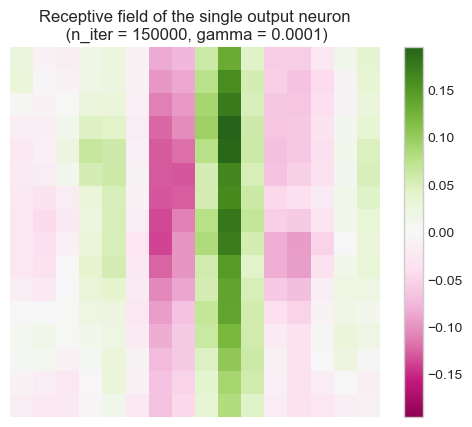

In [3]:
patches = utils.load_dataset('natural_images/')
theta = np.ones((1,))
n_iter = int(150e3)
gamma = 1e-4
net = network.Visual_network(
    n_in = 16*16,
    n_out = 1,
)
untrained_weights = net.weights.copy()
utils.train_network(net, patches, n_iter, theta, gamma)
utils.show_RF(net.weights, 16, title=f"Receptive field of the single output neuron\n (n_iter = {n_iter}, gamma = {gamma})")

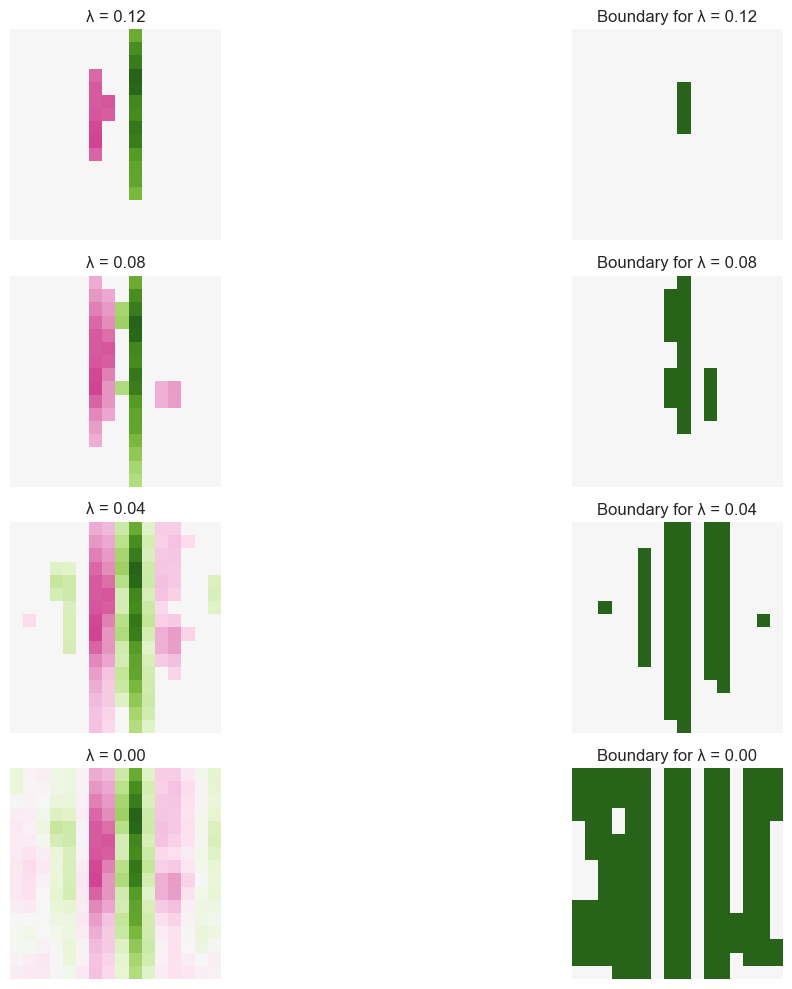

In [4]:
n_lambdas = 4
fig, axes = plt.subplots(n_lambdas, 2, figsize=(15, 10))
lambdas = np.linspace(0.12, 0.0, n_lambdas)
for i, lambda_ in enumerate(lambdas):
   W_lambda = utils.threshold_weights(net.weights, lambda_)
   W_boundary, _ = utils.find_boundary(W_lambda)
   max_value = np.max(np.abs(W_lambda))
   axes[i, 0].imshow(W_lambda.reshape(16, 16), cmap='PiYG', vmin=-max_value, vmax=max_value)
   axes[i, 0].set_title(f'λ = {lambda_:.2f}')
   axes[i, 0].axis('off')
   max_value = np.max(np.abs(W_boundary))
   axes[i, 1].imshow(W_boundary.reshape(16, 16), cmap='PiYG', vmin=-max_value, vmax=max_value)
   axes[i, 1].set_title(f'Boundary for λ = {lambda_:.2f}')
   axes[i, 1].axis('off')
plt.tight_layout()
plt.show()


#### Answer:
When $\lambda = 0$ the thresholding step does nothing because we keep every weight in the receptive-field matrix and given that the RF typically contains a mixture of positive and negative values at many neighbouring pixels, almost every interior pixel now satisfies the criterion of “both-signs in the $3 × 3$ patch”. 
The result is that the boundary mask blows up into a huge and noisy blocky carpet that covers most of the active area, so a single straight‐line fit will be unstable or biased, because it’s forced to accommodate lots of spurious points.

### 2.5, 2.6, 2.7

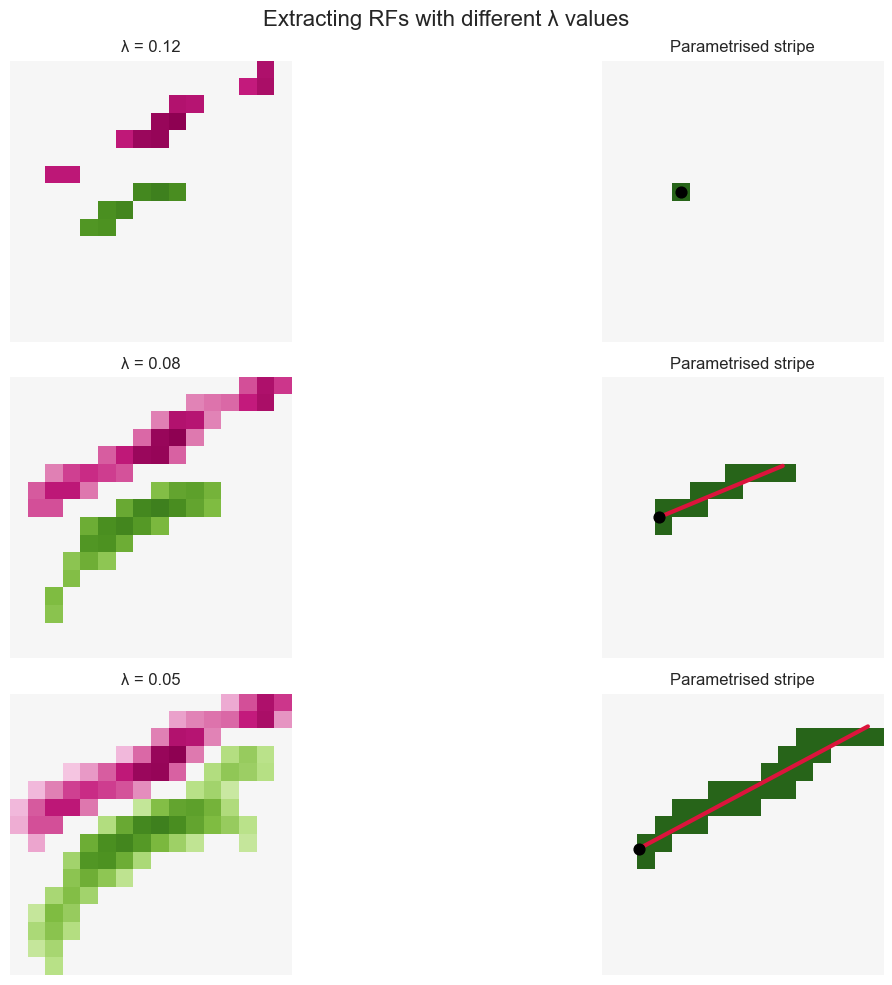

In [5]:
seed = 7
lambdas = np.linspace(0.12, 0.05, 3)
n_trials = len(lambdas)
fig, axes = plt.subplots(n_trials, 2, figsize=(15, 10))
fig.suptitle(f'Extracting RFs with different λ values', fontsize=16)
n_iter = int(150e3)
tau = 1e2

gamma = 1e-5
rfs = []
for i,lambda_ in enumerate(lambdas):
    net = network.Visual_network(
        n_in = 16*16,
        n_out = 1,
        seed=seed,
    )
    theta = np.zeros((1,))
    utils.train_network(
        net=net,
        patches=patches,
        theta=theta,
        n_iter=n_iter,
        gamma=gamma,
        seed=seed,
        tau=tau,
    )
    W_lambda = utils.threshold_weights(net.weights, lambda_)
    W_boundary, coordinates = utils.find_boundary(W_lambda)
    alpha, beta = utils.linear_regression(coordinates)
    max_value = np.max(np.abs(W_lambda))
    axes[i, 0].imshow(W_lambda.reshape(16, 16), cmap='PiYG', vmin=-max_value, vmax=max_value)
    axes[i, 0].set_title(f'λ = {lambda_:.2f}')
    axes[i, 0].axis('off')
    max_value = np.max(np.abs(W_boundary))
    axes[i, 1].imshow(W_boundary.reshape(16, 16), cmap='PiYG', vmin=-max_value, vmax=max_value)
    axes[i, 1].set_title(f'Boundary for λ = {lambda_:.2f}')
    axes[i, 1].axis('off')
    params = utils.find_parameters(coordinates, alpha, beta)
    utils.draw_segment(params, 16, ax=axes[i, 1]);
plt.tight_layout()
plt.show()

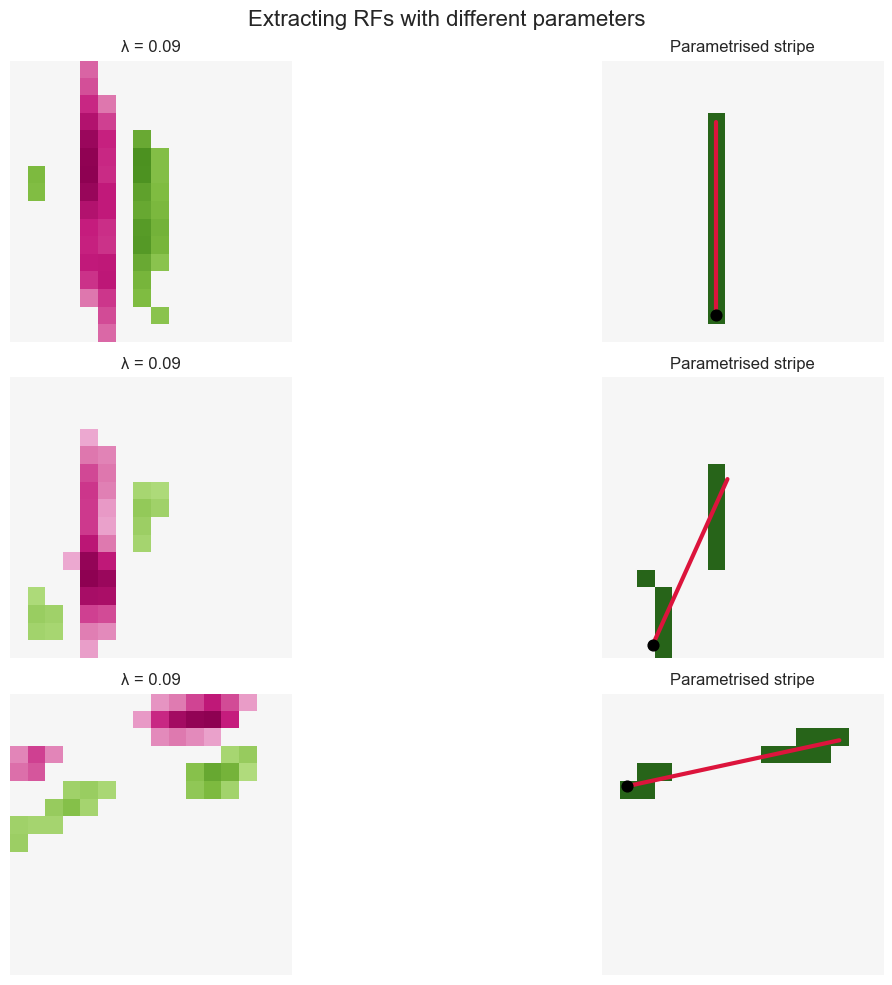

In [19]:
seeds = range(3)
n_trials = len(seeds)
fig, axes = plt.subplots(n_trials, 2, figsize=(15, 10))
fig.suptitle(f'Extracting RFs with different parameters', fontsize=16)

n_iter = int(150e3)
tau = 1e2

gamma = 1e-5
rfs = []
for i,seed in enumerate(seeds):
    net = network.Visual_network(
        n_in = 16*16,
        n_out = 1,
        seed=seed,
    )
    theta = np.zeros((1,))
    utils.train_network(
        net=net,
        patches=patches,
        theta=theta,
        n_iter=n_iter,
        gamma=gamma,
        seed=seed,
        tau=tau,
    )
    lambda_ = 0.09
    W_lambda = utils.threshold_weights(net.weights, lambda_)
    W_boundary, coordinates = utils.find_boundary(W_lambda)
    if coordinates.ndim < 2:
        print(f"No boundary found for seed {seed} and lambda {lambda_}. Skipping.")
        continue
    alpha, beta = utils.linear_regression(coordinates)
    max_value = np.max(np.abs(W_lambda))
    axes[i, 0].imshow(W_lambda.reshape(16, 16), cmap='PiYG', vmin=-max_value, vmax=max_value)
    axes[i, 0].set_title(f'λ = {lambda_:.2f}')
    axes[i, 0].axis('off')
    max_value = np.max(np.abs(W_boundary))
    axes[i, 1].imshow(W_boundary.reshape(16, 16), cmap='PiYG', vmin=-max_value, vmax=max_value)
    axes[i, 1].set_title(f'Boundary for λ = {lambda_:.2f}')
    axes[i, 1].axis('off')
    params = utils.find_parameters(coordinates, alpha, beta)
    utils.draw_segment(params, 16, ax=axes[i, 1])
plt.tight_layout()
plt.show()

### 2.8

Training networks with different seeds:   0%|          | 0/20 [00:00<?, ?it/s]

Training networks with different seeds:   0%|          | 0/20 [00:00<?, ?it/s]

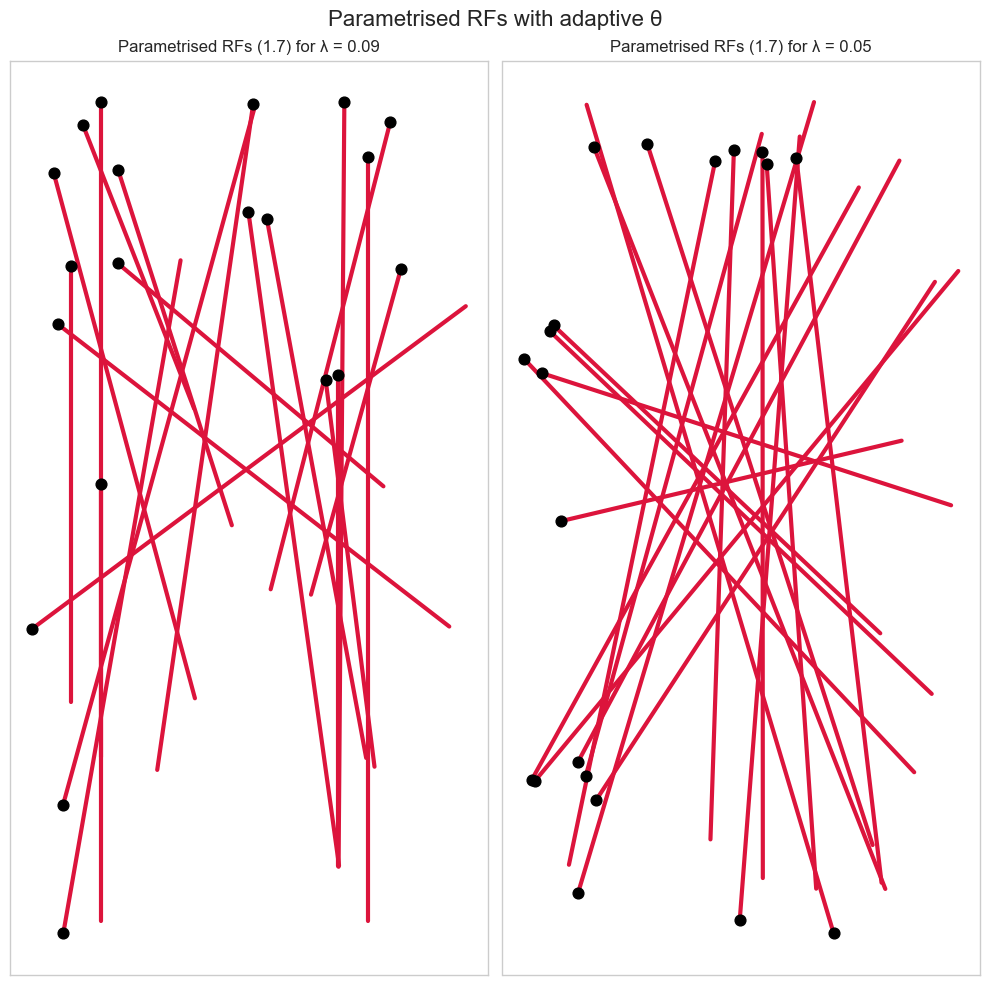

In [20]:
n_iter = int(150e3)
n_trials = 20
tau = 1e2
seeds = range(n_trials)
gammas = [1e-4]
lambdas = [0.09, 0.05]

fig, axs = plt.subplots(1, len(lambdas), figsize=(10, 10))
for i, lambda_ in enumerate(lambdas):
    to_draw = []
    for gamma in gammas:
        for seed in tqdm(seeds, desc="Training networks with different seeds"):
            net = network.Visual_network(
                n_in = 16*16,
                n_out = 1,
                seed=seed,
            )
            theta = np.zeros((1,))
            utils.train_network(
                net=net,
                patches=patches,
                theta=theta,
                n_iter=n_iter,
                gamma=gamma,
                seed=seed,
                tau=tau,
            )
            W_lambda = utils.threshold_weights(net.weights, lambda_)
            W_boundary, coordinates = utils.find_boundary(W_lambda)
            if len(coordinates) == 0:
                print(f"No boundary found for seed {seed} and lambda {lambda_}. Skipping.")
                continue
            alpha, beta = utils.linear_regression(coordinates)
            params = utils.find_parameters(coordinates, alpha, beta)
            to_draw.append(params)
    for params in to_draw:
        utils.draw_segment(params, 16, ax=axs[i], title =f'Parametrised RFs (1.7) for λ = {lambda_:.2f}')
fig.suptitle('Parametrised RFs with adaptive θ', fontsize=16)
plt.tight_layout()
plt.show()

        

Training networks with different seeds:   0%|          | 0/20 [00:00<?, ?it/s]

Training networks with different seeds:   0%|          | 0/20 [00:00<?, ?it/s]

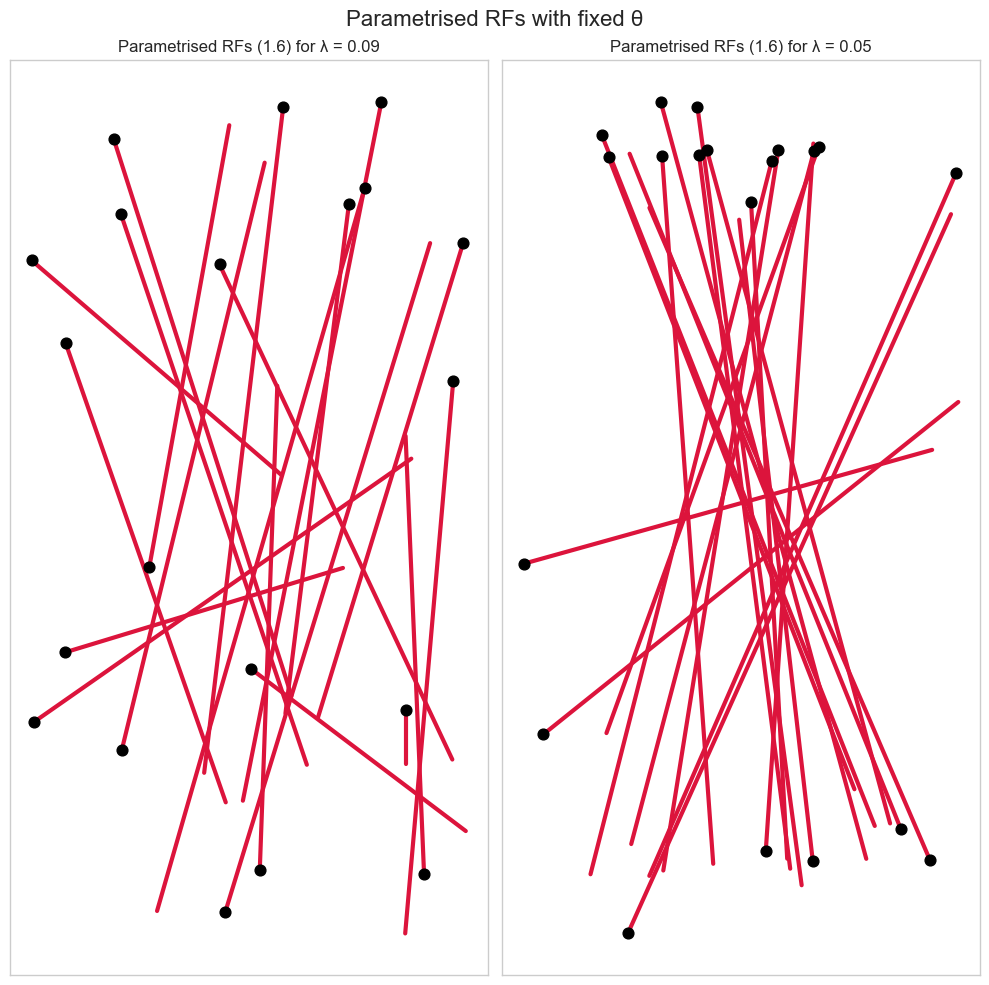

In [21]:
n_iter = int(150e3)
n_trials = 20
tau = 1e2
seeds = range(n_trials)
gammas = [1e-4]
lambdas = [0.09, 0.05]

fig, axs = plt.subplots(1, len(lambdas), figsize=(10, 10))
for i, lambda_ in enumerate(lambdas):
    to_draw = []
    for gamma in gammas:
        for seed in tqdm(seeds, desc="Training networks with different seeds"):
            net = network.Visual_network(
                n_in = 16*16,
                n_out = 1,
                seed=seed,
            )
            theta = np.ones((1,))
            utils.train_network(
                net=net,
                patches=patches,
                theta=theta,
                n_iter=n_iter,
                gamma=gamma,
                seed=seed,
            )
            W_lambda = utils.threshold_weights(net.weights, lambda_)
            W_boundary, coordinates = utils.find_boundary(W_lambda)
            if len(coordinates) == 0:
                print(f"No boundary found for seed {seed} and lambda {lambda_}. Skipping.")
                continue
            alpha, beta = utils.linear_regression(coordinates)
            params = utils.find_parameters(coordinates, alpha, beta)
            to_draw.append(params)
    for params in to_draw:
        utils.draw_segment(params, 16, ax=axs[i], title =f'Parametrised RFs (1.6) for λ = {lambda_:.2f}')
fig.suptitle('Parametrised RFs with fixed θ', fontsize=16)
plt.tight_layout()
plt.show()

#### Answer:
**Orientation**

* Fixed-$\theta$: by looking at the orientationthe bars align mostly vertical or steeply tilted.
The network keeps finding the same “easy” feature: a near-vertical edge that is abundant in the given natural image dataset. Most of the lengths are in a narrow band and the black start-dots group in the central strip of the
$16×16$ patch.  Once a good-enough edge is found the weights stabilise
early, so many seeds end up on the same “central” solution.

* Adaptive-$\theta$: orientations fan out over the whole degree
range (still with a bias toward the vertical direction).The sliding threshold forces neurons that fire too much to depress
their current weights and search for a new edge: that push makes different seeds settle on different tilts. The adaptive-$\theta$ doesn’t just rotate the segment, it sometimes lets it grow longer (when the neuron lowers its gain and needs a broader
feature) or shorter (when it raises its gain). Starting dots (locations) are sprinkled all around the patch, including
corners.  Because $\theta$ keeps drifting toward ⟨$y²$⟩, the neuron continues
to reshape after the first solution, exploring more of the receptive
field before converging.

We can then conclude that learning $\theta$ adds competition and diversity because we get a broader spread in
orientation, a wider set of starting positions and a larger variance in
stripe length compared to the fixed-$\theta$ setting, where instead the population stays more redundant.


### 2.9
#### Answer:
This specific parametrisation is good as long as the receptive field genuinely looks like one elongated bar of alternating sign (“simple-cell” edge detector).  
It breaks down the moment the RF gets more complicated or deviates from the one-bar picture, for example:
* if there are two parallel bars the algorithm will pick only one of them or place an in-between line;  
* if the structure is curved, blob-like or centre–surround, forcing a straight segment is plainly misleading;  
* the fitted line can even flip or shrink to zero length when the threshold λ removes too many pixels.

For an alternative one could think of using a more flexible model that can capture a wider variety of receptive-field shapes like a 2-D Gabor fit or a difference of Gaussians model.


### [Bonus] Showing parametrised RFs on the custom dataset

In [22]:
ext = '.jpg'
path = 'custom_images/'

custom_patch_list = []
custom_edges_patch_list = []
for filename in os.listdir(path):
    if filename.endswith(ext): 
        img = Image.open(os.path.join(path, filename))
        
        img = img.convert('L')
        
        normalized_img = utils.normalize(img)
        
        patches_normalized = utils.extract_patches(normalized_img, verbose=False)
        
        custom_patch_list.extend(patches_normalized)
        
        

Training networks with different seeds:   0%|          | 0/20 [00:00<?, ?it/s]

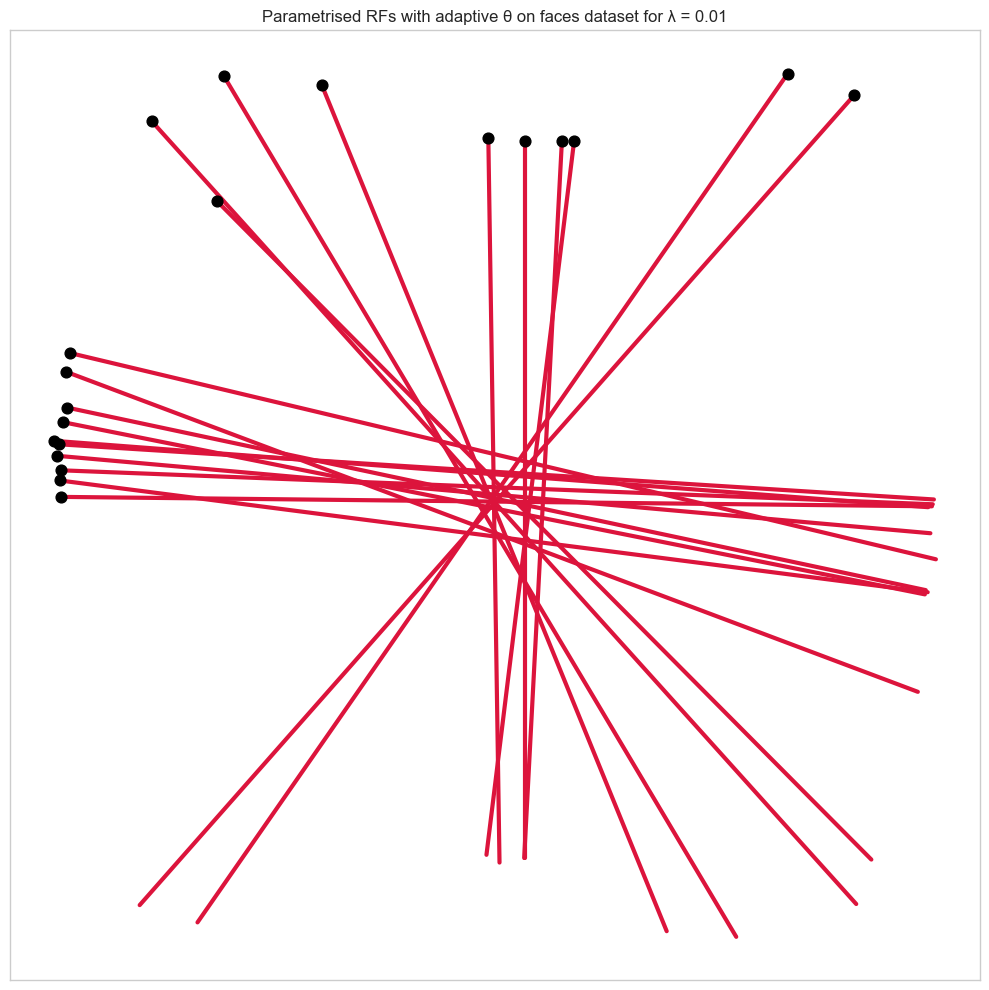

In [23]:
n_iter = int(150e3)
n_trials = 20
tau = 1e2
seeds = range(n_trials)
gammas = [1e-5]
lambdas = [0.009]#, 0.05]

fig, axs = plt.subplots(1, len(lambdas), figsize=(10, 10))
for i, lambda_ in enumerate(lambdas):
    to_draw = []
    for gamma in gammas:
        for seed in tqdm(seeds, desc="Training networks with different seeds"):
            net = network.Visual_network(
                n_in = 16*16,
                n_out = 1,
                seed=seed,
            )
            theta = np.zeros((1,))
            utils.train_network(
                net=net,
                patches=custom_patch_list,
                theta=theta,
                n_iter=n_iter,
                gamma=gamma,
                seed=seed,
                tau=tau,
            )
            W_lambda = utils.threshold_weights(net.weights, lambda_)
            W_boundary, coordinates = utils.find_boundary(W_lambda)
            if len(coordinates) == 0:
                print(f"No boundary found for seed {seed} and lambda {lambda_}. Skipping.")
                continue
            alpha, beta = utils.linear_regression(coordinates)
            params = utils.find_parameters(coordinates, alpha, beta)
            to_draw.append(params)
    for params in to_draw:
        utils.draw_segment(params, 16, ax=axs, title =f'Parametrised RFs with adaptive θ on faces dataset for λ = {lambda_:.2f}')
plt.tight_layout()
plt.show()

        